In [7]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import sklearn.tree as tree
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import learn_w as learn

# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

# Load jupyter black extension for formatting (only relevant in Jupyter Notebook)
# %load_ext jupyter_black

# Set visualization aesthetics for seaborn
sns.set(font_scale=1.25, style="whitegrid")

# Set seed for reproducibility
np.random.seed(42)

# Define sample sizes
n_trial = 1000  # Sample size for trial (S=1)
n_target = 5000  # Sample size for target population (S=0)
n = n_trial + n_target  # Total sample size

# Generate S indicator (1 for trial, 0 for target population)
S_trial = np.ones(n_trial, dtype=int)
S_target = np.zeros(n_target, dtype=int)
S = np.concatenate([S_trial, S_target])  # Concatenating trial and target groups

# Define probability of being a black female in trial (5%) and target (20%)
p_black_female_trial = 0.05
p_black_female_target = 0.2

# Generate race and gender independently, ensuring correct black female proportions
race_black_trial = np.random.binomial(1, 0.2, n_trial)  # Adjusted probability for trial
race_black_target = np.random.binomial(
    1, 0.3, n_target
)  # Adjusted probability for target

gender_male_trial = np.random.binomial(1, 0.5, n_trial)  # Assume gender is balanced
gender_male_target = np.random.binomial(1, 0.5, n_target)

# Compute black female indicator before adjustments
black_female_trial = (race_black_trial == 1) & (gender_male_trial == 0)
black_female_target = (race_black_target == 1) & (gender_male_target == 0)

# Adjust black female probability in trial dataset
while black_female_trial.mean() > p_black_female_trial:
    idx = np.random.choice(
        np.where(black_female_trial)[0]
    )  # Select an index where black female is 1
    race_black_trial[idx] = 0  # Change to non-black
    black_female_trial[idx] = False  # Update indicator

while black_female_trial.mean() < p_black_female_trial:
    idx = np.random.choice(
        np.where(~black_female_trial)[0]
    )  # Select an index where black female is 0
    race_black_trial[idx] = 1  # Change to black
    black_female_trial[idx] = True  # Update indicator

# Adjust black female probability in target dataset
while black_female_target.mean() > p_black_female_target:
    idx = np.random.choice(np.where(black_female_target)[0])
    race_black_target[idx] = 0
    black_female_target[idx] = False

while black_female_target.mean() < p_black_female_target:
    idx = np.random.choice(np.where(~black_female_target)[0])
    race_black_target[idx] = 1
    black_female_target[idx] = True

# Generate education >12y with a fixed probability (10%)
education_trial = np.random.binomial(1, 0.1, n_trial)
education_target = np.random.binomial(1, 0.1, n_target)

# Combine all covariates
race_black = np.concatenate([race_black_trial, race_black_target])
gender_male = np.concatenate([gender_male_trial, gender_male_target])
education_12y = np.concatenate([education_trial, education_target])

# Generate treatment assignment (randomized for both trial and target groups)
voucher = np.random.binomial(1, 0.5, n)

# Define treatment effect and interactions
beta_0 = 1  # Baseline effect
beta_1 = 1  # Effect of treatment
beta_2_race = -0.5  # Effect of being black
beta_2_gender = -0.3  # Effect of being male
beta_2_edu = 1  # Effect of having education >12 years
beta_3 = 15  # Interaction effect between treatment and education

# Generate outcome variable (income)
income = (
    beta_0
    + beta_1 * voucher
    + beta_2_race * race_black
    + beta_2_gender * gender_male
    + beta_2_edu * education_12y
    + beta_3 * voucher * education_12y  # Interaction term
)

# Create DataFrame to store generated data
df = pd.DataFrame(
    {
        "S": S,  # Sample indicator (trial or target)
        "race_black": race_black,  # Binary race variable (1 = black, 0 = non-black)
        "gender_male": gender_male,  # Binary gender variable (1 = male, 0 = female)
        "education_12y": education_12y,  # Binary education variable (1 = >12 years, 0 = otherwise)
        "voucher": voucher,  # Treatment assignment
        "income": income,  # Outcome variable
    }
)

# Copy dataset for further processing
res = df.copy(deep=True)

# Define covariates, treatment, and outcome variables for modeling
X = df[["race_black", "gender_male", "education_12y"]]
T = df["voucher"]
S = df["S"]
Y = df["income"]

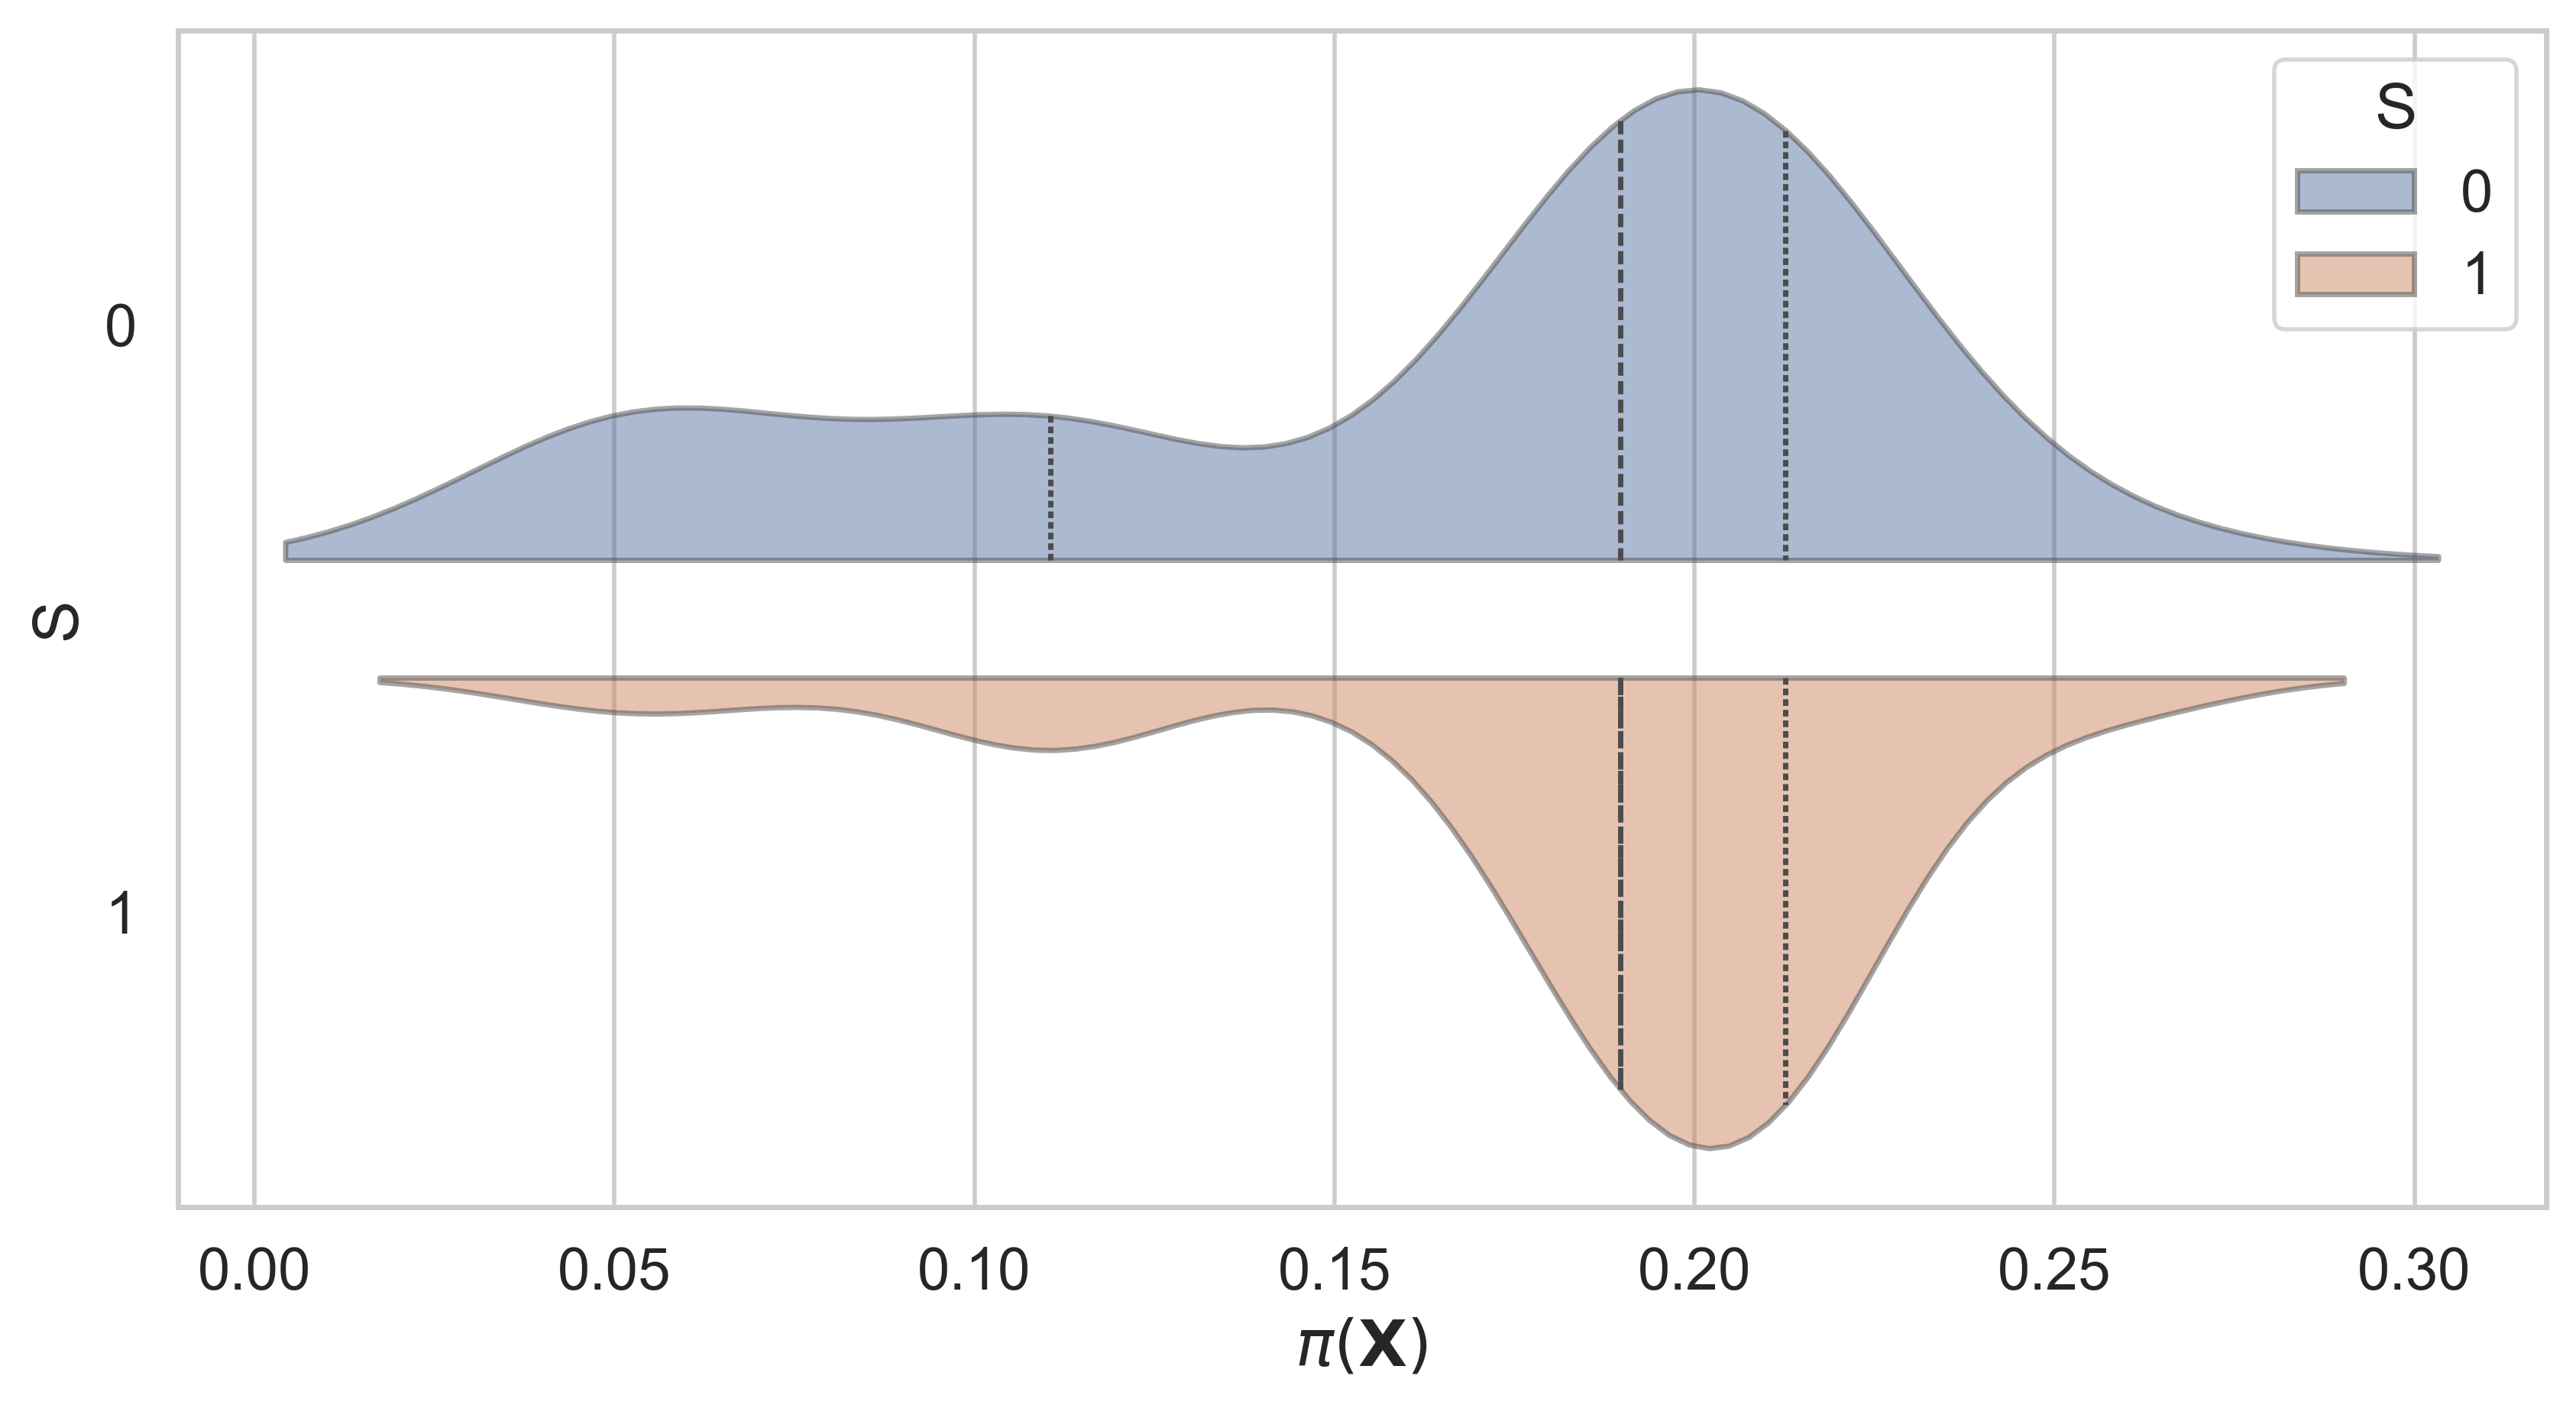

In [12]:
# --- Traditional Trimming Method ---

# Fit a decision tree classifier to predict selection probability P(S=1 | X)
selection_score_m = tree.DecisionTreeClassifier().fit(X, S)
res["pi(x)"] = selection_score_m.predict_proba(X)[:, 1]  # Compute selection scores

# Define trimming rule: Keep samples where P(S=1 | X) > 0.1
res["w_trim"] = res["pi(x)"] > 0.1

# Visualizing distribution of selection scores using a violin plot
fig,ax = plt.subplots(figsize=(10,5),dpi=400)
sns.violinplot(
    data=res,
    y="S",
    hue="S",
    x="pi(x)",
    orient="h",
    split=True,
    inner="quart",
    alpha=0.5,
    bw=0.4,ax=ax
)
plt.xlabel(r"$\pi(\mathbf{X})$")
plt.savefig("toy_example_selection_score.png")

[Text(0.4, 0.8333333333333334, 'race_black <= 0.5\ngini = 0.258\nsamples = 6000\nvalue = [912, 5088]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 4142\nvalue = [0, 4142]'),
 Text(0.6, 0.5, 'gender_male <= 0.5\ngini = 0.5\nsamples = 1858\nvalue = [912, 946]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 912\nvalue = [912, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 946\nvalue = [0, 946]')]

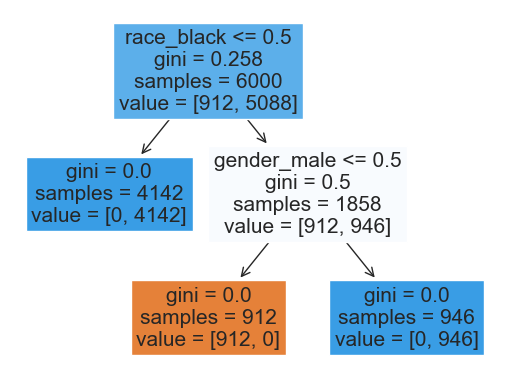

In [5]:
# Fit a decision tree to explain trimming results
explain_trim = tree.DecisionTreeClassifier().fit(X, res["w_trim"])

# Plot the decision tree explaining trimming
tree.plot_tree(explain_trim, feature_names=X.columns, filled=True)

ATE Est: 2.6029
leaf             0.333333
race_black       0.014779
gender_male      0.020035
education_12y    0.631853
dtype: float64


[Text(0.5, 0.75, 'education_12y <= 0.5\ngini = 0.194\nsamples = 1000\nvalue = [109, 891]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 891\nvalue = [0, 891]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 109\nvalue = [109, 0]')]

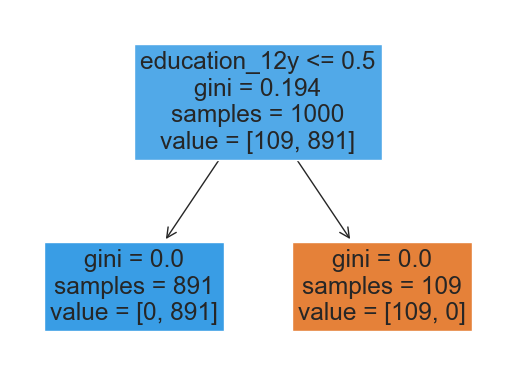

In [3]:
# --- ROOT Model Training ---

# Run ROOT framework (Random Optimization Over Trees) for causal analysis
np.random.seed(42)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=df,
    outcome="income",
    treatment="voucher",
    sample="S",
    leaf_proba=0.5,
    num_trees=1000,
    vote_threshold=0.5,
)

# Visualize the fitted tree from ROOT framework
tree.plot_tree(f, feature_names=X.columns, filled=True)